### Access the data

In [445]:
import pandas as pd

# Load the dataset as pd
df = pd.read_csv("./dataset/fliptop_videos.csv")
df.shape


(1749, 8)

### Understand the Structure

In [446]:
# df.head()
df.info()
# df.describe()
# df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        1749 non-null   object 
 1   title           1749 non-null   object 
 2   description     1748 non-null   object 
 3   published_at    1749 non-null   object 
 4   view_count      1749 non-null   int64  
 5   like_count      1749 non-null   int64  
 6   comment_count   1749 non-null   int64  
 7   video_duration  1749 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 109.4+ KB


### Assess Data Quality

In [447]:
# check for null records
df.isnull().sum()
df[df["description"].isnull()]

# check for duplicate observations
df.duplicated()
df[df.duplicated()]

,video_id,title,description,published_at,view_count,like_count,comment_count,video_duration


### Filter out non-battle titles/videos

In [448]:
# filter titles with "vs" substring
df = df[df["title"].str.contains("vs", case=True)]
df = df[df["title"].str.startswith("FlipTop - ")]
df = df.drop(["video_id", "description"], axis=1) # remove video_id column
df.head(3)

,title,published_at,view_count,like_count,comment_count,video_duration
0,FlipTop - Caspher vs CRhyme,2025-07-02T13:23:54Z,144755,3192,624,1952.0
5,FlipTop - Negho Gy vs Hespero,2025-06-25T12:44:16Z,334567,4635,764,1929.0
7,FlipTop - Ruffian vs JDee,2025-06-21T12:23:04Z,618133,12537,2178,2314.0


### Removing also Royal Rumbles

In [449]:
df = df[~df["title"].str.contains("royal rumble", case=False)]
df = df[~df["title"].str.contains("Shernan vs M Zhayt vs Pistolero vs Lhipkram vs Romano", case=False)]
df = df[~df["title"].str.contains("5 on 5 Battle", case=False)]

### Transform "published_at" and add Date Fields

In [450]:
df["published_at"] = pd.to_datetime(df["published_at"])
df["date"] = df["published_at"].dt.date
df["year"] = df["published_at"].dt.year
df["month"] = df["published_at"].dt.month
df["week"] = df["published_at"].dt.isocalendar().week

df = df.drop("published_at", axis=1)
df.head(3)

,title,view_count,like_count,comment_count,video_duration,date,year,month,week
0,FlipTop - Caspher vs CRhyme,144755,3192,624,1952.0,2025-07-02,2025,7,27
5,FlipTop - Negho Gy vs Hespero,334567,4635,764,1929.0,2025-06-25,2025,6,26
7,FlipTop - Ruffian vs JDee,618133,12537,2178,2314.0,2025-06-21,2025,6,25


### Extract Emcee Name in the Title column

In [451]:
# using regular expression for extracting emcee names

df['emcee_1'] = df['title'].str.extract(r'FlipTop - (.*?) vs ')
df['emcee_2'] = df['title'].str.extract(r' vs (.*?)(?: @| -| \||\*| pt\.| \(|$)')

df.sample(5)

# df.loc[[1400,620,1234,1736]]

,title,view_count,like_count,comment_count,video_duration,date,year,month,week,emcee_1,emcee_2
1591,FlipTop - Third D vs Mocks Wun,219355,257,305,694.0,2012-01-11,2012,1,2,Third D,Mocks Wun
832,FlipTop - Poison13 vs Dosage @ Isabuhay 2019,1211862,10390,2196,1315.0,2019-05-01,2019,5,18,Poison13,Dosage
1428,FlipTop - Juan Lazy vs Rudic - Isabuhay Tournament,648790,1078,1182,1587.0,2013-05-11,2013,5,19,Juan Lazy,Rudic
486,FlipTop - SirDeo vs C-Quence,778456,15495,2134,1531.0,2021-05-22,2021,5,20,SirDeo,C-Quence
872,FlipTop - Shernan vs Lanzeta,4952524,40559,6083,1824.0,2019-01-13,2019,1,2,Shernan,Lanzeta


### Duplicating the data
##### Each emcee is considered contributor to the battle's performance metrics (views, likes, comments, etc). 

In [452]:
df1 = df[["title", "emcee_1", "view_count", "like_count", "comment_count", "video_duration", "date", "year", "month", "week"]].rename(columns={"emcee_1": "emcee_name"})
df2 = df[["title", "emcee_2", "view_count", "like_count", "comment_count", "video_duration", "date", "year", "month", "week"]].rename(columns={"emcee_2": "emcee_name"})
df_full = pd.concat([df1, df2], ignore_index=True)


In [453]:
# save data for manual validation
df_full.to_csv("dataset/test_file.csv", index=False, encoding="utf-8")

# Exploratory Data Analysis

In [454]:
print(df_full.columns)

Index(['title', 'emcee_name', 'view_count', 'like_count', 'comment_count',
       'video_duration', 'date', 'year', 'month', 'week'],
      dtype='object')


#### Fliptop Total Number of Battles, Views, Video Duration, Likes, & Comments (excluding non-battle and royal rumbles)

In [455]:
# print("Fliptop Total Number of Battles, Views, Video Duration, Likes, & Comments (excluding non-battle and royal rumbles)")
print(f"{df["title"].count():,} battles uploaded")
print(f"{df["view_count"].sum():,} views")
print(f"{df["video_duration"].sum():,.0f} seconds")
print(f"{df["like_count"].sum():,} likes")

print("======================")

print(f"avg of {(df["view_count"].sum() / df["title"].count()):,.0f} views per battle")
print(f"avg of {(df["video_duration"].sum() / df["title"].count()):,.0f} seconds per video")
print(f"avg of {(df["like_count"].sum() / df["title"].count()):,.0f} likes per battle")
print(f"av of {(df["comment_count"].sum() / df["title"].count()):,.0f} comments per battle")



1,291 battles uploaded
2,616,843,001 views
1,913,136 seconds
19,005,303 likes
avg of 2,026,989 views per battle
avg of 1,482 seconds per video
avg of 14,721 likes per battle
av of 2,549 comments per battle


### Yearly Number of Views

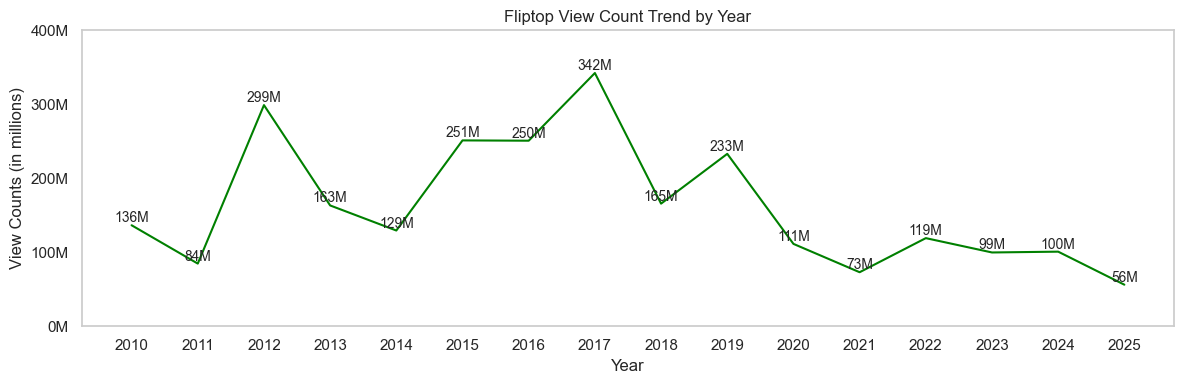

In [456]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Aggregate total views per year
yearly_views = df.groupby("year")["view_count"].sum().reset_index()

# Auto-generate y-ticks up to max view count (rounded to nearest 100M)
max_views = yearly_views["view_count"].max()
step = 100_000_000
yticks = list(range(0, int(max_views + step), step))
ytick_labels = [f'{int(y/1_000_000)}M' for y in yticks]

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(yearly_views["year"], yearly_views["view_count"], color="green")

plt.title("Fliptop View Count Trend by Year")
plt.xlabel("Year")
plt.ylabel("View Counts (in millions)")

# Customize axis
plt.yticks(yticks, ytick_labels)
plt.xticks(yearly_views["year"]) # explicitly show all labels in x

# labels
for x, y in zip(yearly_views["year"], yearly_views["view_count"]):
    plt.text(x, y, f'{int(y/1_000_000)}M', ha='center', va='bottom', fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.show()



### FlipTop View Count Analysis (2010–2025)

- **Peak Year:** 2017 with **342M views**
- **Growth Spurts:** Significant increases in 2012 and 2015–2017
- **Recent Decline:** Viewership fell from 342M in 2017 to just 100M in 2024.


### Top Emcees in 2015-2017

In [457]:
df_1517 = df_full[df_full["year"].isin([2015,2016,2017])]
df_1517 = df_2017[~df_2017["emcee_name"].str.contains("/")]
top_mc_1517 = df_2017.groupby("emcee_name")[["view_count"]].sum().reset_index().nlargest(10, "view_count")
top_mc_1517

,emcee_name,view_count
130,Sinio,151447338
84,Loonie,105577795
126,Shernan,94149497
125,Shehyee,70077165
4,Aklas,57207162
152,Zaito,55368093
143,Tipsy D,53295816
132,Smugglaz,44069252
82,Lil Sisa,43355721
46,Flict-G,40779184


- **Above are top contributors of views from year 2015 - 2017, and most of them are not active anymore in battle rap**

### Top 5 Most Viewed Emcees

In [460]:
print("***battle_count reflects only their solo battles***")

most_viewed_with_metrics = df_full.groupby("emcee_name").agg({
  "view_count": "sum",
  "like_count": "sum",
  "emcee_name": "count"
}).rename(columns={"emcee_name": "battle_count"}).sort_values(by="view_count", ascending=False).reset_index().head(5)

most_viewed = most_viewed_with_metrics["emcee_name"]
most_viewed_with_metrics

***battle_count reflects only their solo battles***


,emcee_name,view_count,like_count,battle_count
0,Sinio,334735445,2379455,19
1,Zaito,235251046,1341723,32
2,Shernan,227197539,2215634,24
3,Loonie,159232243,737526,13
4,Tipsy D,132721867,1018786,21


### View Trends of Top 5 Emcees

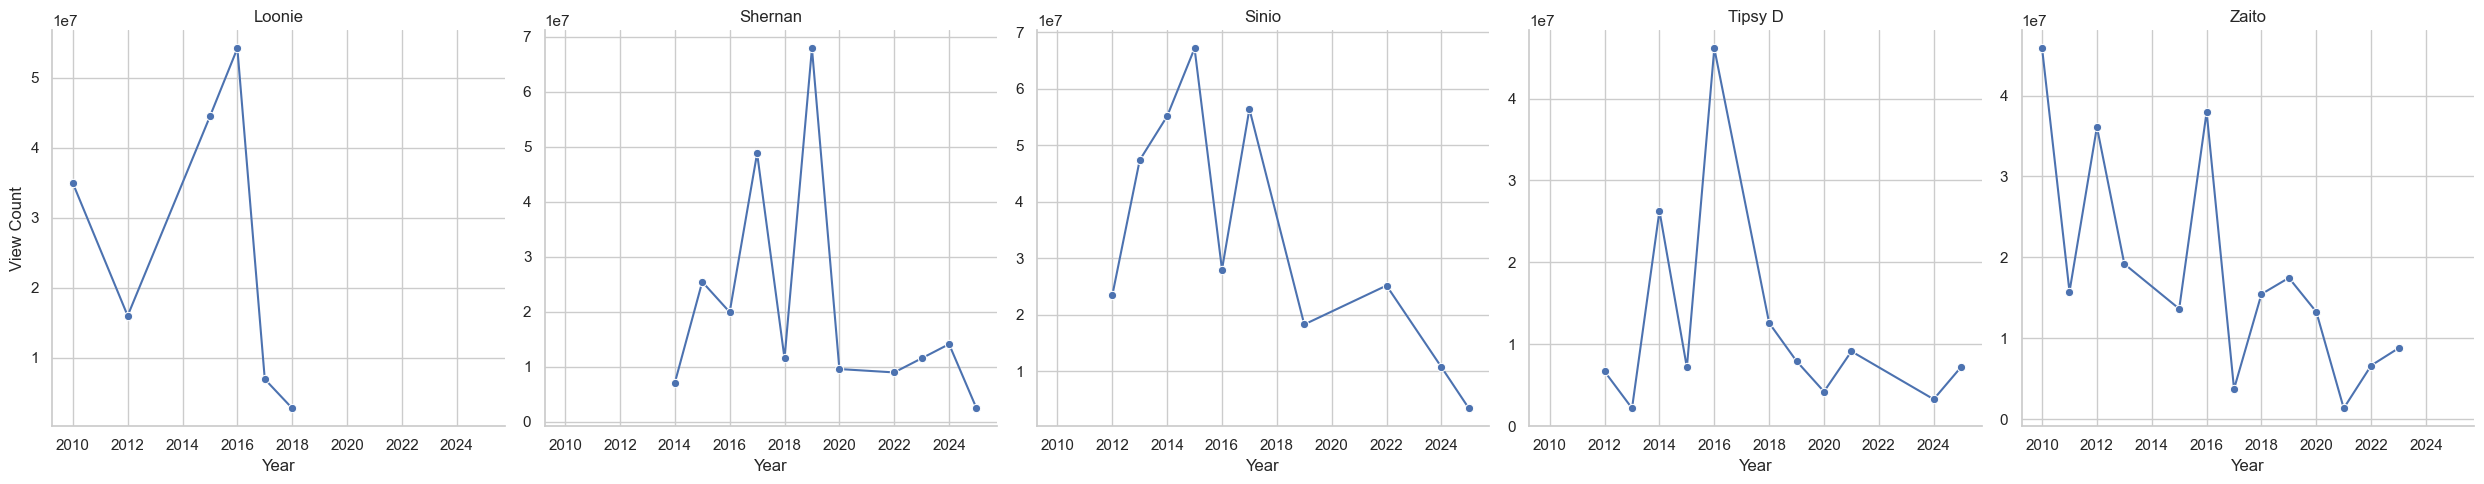

In [459]:
# create summary of top 5 emcees
df_top_5 = df_full[df_full["emcee_name"].isin(most_viewed)]
df_top_5 = df_top_5.groupby(["emcee_name", "year"])[["view_count"]].sum().reset_index()

# Ensure year is sorted for proper plotting
# df_top_5 = df_top_5.sort_values(by=['emcee_name', 'year'])

import seaborn as sns

g = sns.relplot(
    data=df_top_5,
    x="year", y="view_count",
    kind="line",
    col="emcee_name", col_wrap=5,  # 3 plots per row
    marker="o", facet_kws={'sharey': False}
)

g.set_titles("{col_name}")
g.set_axis_labels("Year", "View Count")

plt.tight_layout()
plt.show()

#### Descriptive Analysis (solo battles)
- **Most artists reached their peaked view counts between 2015-2018**
- **Shernan recorded the highest peak with 67.8M in 2019, followed closely by Sinio with 67.1M views in 2015**
- **Loonie has remained inactive since 2018, with no significant viewership data afterwards**